# Text Cleaning, Feature Extraction, and Supervise Learning on Potential Insults

### Warning: Some commentary in the dataset contains profanity and harsh language which may not be suitable for some audiences

In [1]:
# Data came from Kaggle's Impermium competition
# https://www.kaggle.com/c/detecting-insults-in-social-commentary/data?train.csv

# download train.csv as the training set and
# impermium_verification_labels.csv as the test set

In [2]:
# Data
import pandas as pd
import numpy as np
import csv

# Text Data
from bs4 import BeautifulSoup
import re
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from io import StringIO


# Plotting
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import savefig


# Analysis with Random Forests 

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC 



## Get the data

In [3]:
# Set the appropriate path

path = '/Users/KevinSun/Documents/Data Science/'


In [4]:
# Training set 


file = 'train.csv'

path + file

trolls_train = pd.read_csv(path+file)

In [5]:
#Looking at the dimensions of our dataset
trolls_train.shape

(3947, 3)

In [6]:
#Examine the first few rows of our dataset 
trolls_train.head()

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


## Clean the formatting

In [7]:
# Importing Natural Language Toolkit 
import nltk

In [8]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("maxent_treebank_pos_tagger")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kevinsun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kevinsun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /Users/kevinsun/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
def trolls_clean(inputdata):

    lines = []
    for row in inputdata:
        #parsing HTML
        line = BeautifulSoup(str(inputdata), "html.parser")
        #replace emails with _EM tags
        line = re.sub(r'[\w\-][\w\-\.]+@[\w\-][\w\-\.]+[a-zA-Z]{1,4}', '_EM', str(line))
        #replace url's with tags
        line = re.sub(r'\w+:\/\/\S+', r'_U', line)

        ### Format white space
        line = line.replace('\\xa0', ' ')
        line = line.replace('"', ' ')
        line = line.replace('\'', '')
        line = line.replace('_', ' ')
        line = line.replace('-', ' ')
        line = line.replace('\n', ' ')
        line = line.replace('\\n', ' ')
        line = line.replace('\'', ' ')
        line = re.sub(' +', ' ', line)
        line = line.replace('\'', ' ')

        #punctuations and other issues
        line = re.sub(r'([^\.])(\.{2,})', r'\1 _SS\n', line)
        line = re.sub(r'([^!\?])(\?{2,})(\Z|[^!\?])', r'\1 _BQ\n\3', line)
        line = re.sub(r'([^!\?])\?(\Z|[^!\?])', r'\1 _Q\n\2',line)
        line = re.sub(r'([^!\?])!(\Z|[^!\?])', r'\1 _X\n\2', line)
        line = re.sub(r'([a-zA-Z])\1\1+(\w*)', r'\1_EL', line)
        line = re.sub(r'([a-zA-Z])\1\1+(\w*)', r'\1_EL', line)
        line = re.sub(r'(\w+)\.(\w+)', r'\1\2', line)

        lines.append(line)

        #unigrams as phrases
        phrases = re.split(r'[;:\.()\n]', line)
        phrases = [re.findall(r'[\w%\*&#]+', ph) for ph in phrases]
        phrases = [ph for ph in phrases if ph]

        words = []  

        for ph in phrases:
            words.extend(ph)

        tmp = words
        words = []
        new_word = ''
        for word in tmp:
            if len(word) == 1:
                new_word = new_word + word
            else:
                if new_word:
                    words.append(new_word)
                    new_word = ''
                words.append(word)

        # stopwords
        words = [w for w in words if not w in stopwords.words("english")]  

        #Lemmatizing
        lemmatizer = WordNetLemmatizer()

        tagged = []

        for t in words:
            t=t.lower()
            treebank_tag = pos_tag([t])
            tagged.append(treebank_tag)
        
        def get_wordnet_pos(tagged):
            if treebank_tag[0][1].startswith('J'):
                return wordnet.ADJ
            elif treebank_tag[0][1].startswith('V'):
                return wordnet.VERB
            elif treebank_tag[0][1].startswith('N'):
                return wordnet.NOUN
            elif treebank_tag[0][1].startswith('R'):
                return wordnet.ADV
            else:
                return wordnet.NOUN

        postagged = []
        for t in tagged:
            newtag = t[0][0], get_wordnet_pos(t)
            postagged.append(newtag)

        lemmatized = []
        for t in postagged:
            lemmatized.append(lemmatizer.lemmatize(t[0], t[1]))

        for t in lemmatized:
            t = np.asarray(t)
    
        return (lemmatized)

In [10]:
# Create the cleaned training data

trolls_train_x = trolls_train.Comment.apply(trolls_clean)

In [11]:
trolls_train_x

0                                        [you, fuck, dad]
1       [really, dont, understand, point, it, seems, m...
2       [a, xc2, majority, canadian, wrong, unless, yo...
3       [listen, dont, wanna, get, married, man, woman...
4       [c, xe1c, b, u1ea1n, xu, u1ed1ng, u0111, u01b0...
5       [sdl, ok, i, would, hope, theyd, sign, one, ye...
6                                              [yeah, _q]
7       [shut, fuck, rest, faggot, friend, burned, stake]
8       [either, fake, extremely, stupid, _ss, maybe, ...
9       [that, idiot, understands, neither, taxation, ...
10      [jdstorm, dont, wish, injury, happen, own, dou...
11                     [be, careful, jimboog, fork, name]
12                     [tonnyb, or, dont, pay, attention]
13      [hm_el, perhaps, pig, face, get, lay, therefor...
14      [barrettmarson, huh, _q, her, income, 21, 912,...
15      [for, some, reason, u, sound, retarded, lol, d...
16      [you, racist, screen, name, you, pieceofshit, ...
17      [oh, _

## Supervised Learning with the Data

We can apply a number of supervised learning approaches
to this problem. Here we will use RF.

In [12]:
# Convert the cleaned data into a TF-IDF matrix that 
# can provide the supervised learning input.
# This will turn the text strings into vectors.
    
swds = stopwords.words('english')
vect = TfidfVectorizer(analyzer = "word",input="file", ngram_range = (1,3),\
                       min_df = 0, stop_words = swds, max_features=5000)


# StringIO implments the StringIO class
# that allows us to read and write string buffer or
# memory file

docs_new = [StringIO(str(x)) for x in trolls_train_x]
trolls_tf = vect.fit_transform(docs_new).toarray()

   

In [13]:
# We can see the output vocabulary from the vectorizer, 
# This shows a list of all of the distinct terms in the corpus.
   
vocab = vect.get_feature_names()
print(pd.Series(vocab)[:1000])
   

0                   000
1                    06
2                    07
3                    08
4                 0bama
5              0bama uu
6         0bama uu 2o12
7                    10
8               10 year
9                   100
10                 1000
11                 10th
12                   11
13                   12
14                   13
15                   14
16                   15
17           15 million
18                   16
19                   17
20                   18
21         18 remaining
22                 1866
23                   19
24                 1959
25                 1961
26                 1970
27                 1971
28                 1973
29                 1975
             ...       
970          consenting
971    consenting adult
972         consequence
973        conservative
974       conservatives
975            consider
976          considered
977         considering
978          consistent
979          conspiracy
980          con

In [14]:
# Test data

file = 'impermium_verification_labels.csv'

trolls_test = pd.read_csv(path + file)

In [15]:
# Clean the test data
# Test Data cleaning

trolls_test_x = trolls_test["Comment"].apply(trolls_clean)

In [16]:
# Get the TF-IDF matrixfor the test data

#vect1 = TfidfVectorizer(analyzer = "word",input="file", ngram_range = (1,3), min_df = 0, stop_words = swds)
docs_new_test = [StringIO(str(x)) for x in trolls_test_x]
trolls_tf_test = vect.fit_transform(docs_new_test).toarray()




In [17]:
# Random Forest 

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_curve, auc


In [18]:
# Get RF model

rf = RandomForestClassifier(n_estimators = 1000,\
                            max_depth = 10, max_features = 1000)


rf.fit(trolls_tf, trolls_train["Insult"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=1000, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
# Test set for rf

print(rf.score(trolls_tf_test, trolls_test["Insult"]))

0.517673378076


In [20]:
# ROC Curve

# test_pred = rf.predict_proba(tf1)
test_pred = rf.predict_proba(trolls_tf_test)

troll_pred = test_pred[:,1]

fpr, tpr, _ = roc_curve(trolls_test["Insult"], troll_pred)
roc_auc = auc(fpr, tpr)
print("Random Forest benchmark AUC, 1000 estimators")
print(roc_auc)

Random Forest benchmark AUC, 1000 estimators
0.513304163199


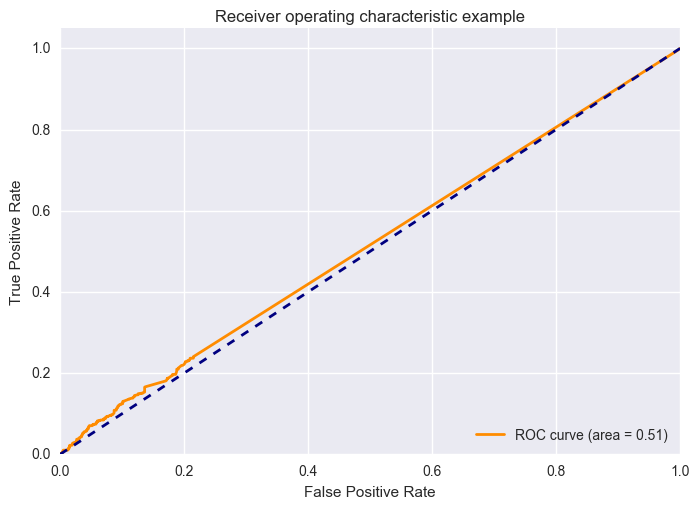

In [21]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### SVM Classifier

In [22]:
from sklearn.svm import SVC

In [23]:
# Get SVM
sv = SVC(probability = True)


sv.fit(trolls_tf, trolls_train["Insult"])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
# Test set for sv

print(sv.score(trolls_tf_test, trolls_test["Insult"]))

0.518120805369


In [25]:
# ROC Curve

# test_pred = rf.predict_proba(tf1)
test_pred_sv = sv.predict_proba(trolls_tf_test)

troll_pred_sv = test_pred_sv[:,1]

fpr, tpr, _ = roc_curve(trolls_test["Insult"], troll_pred_sv)
roc_auc = auc(fpr, tpr)
print("Support Vector Classifier benchmark AUC")
print(roc_auc)

Support Vector Classifier benchmark AUC
0.474484150466


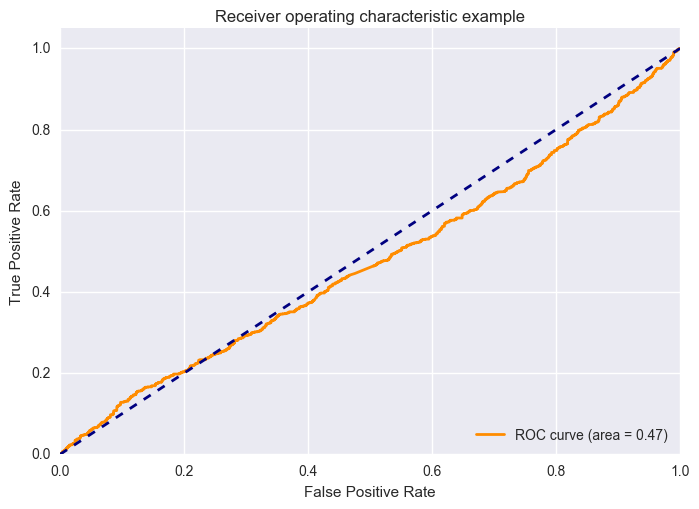

In [26]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()